<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Importing modules.
    </div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Loading dataset with reduced memory usage
    </div>

In [2]:
train_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv', low_memory=True)
test_logs = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv', low_memory=True)
train_scores = pd.read_csv('/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv', low_memory=True)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b>Merging datasets
    </div>

In [3]:
train_data = pd.merge(train_logs, train_scores, on='id')


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Defining features and target variable
    </div>

In [4]:
features = train_data.drop(['id', 'score'], axis=1)
target = train_data['score']

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Function to preprocess data
    </div>

In [5]:
def preprocess_data(data):
    # Using pd.factorize for categorical features as low memory alternative instead of one hot encoder
    cat_cols = ['activity', 'down_event', 'up_event', 'text_change']
    
    for col in tqdm(cat_cols):
        data[col], _ = pd.factorize(data[col])
    
    # Handling missing values
    data.fillna(0, inplace=True)
    
    return data

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Preprocessing data
    </div>

In [6]:
features = preprocess_data(features)

100%|██████████| 4/4 [00:03<00:00,  1.29it/s]


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Splitting data into train and val sets
    </div>

In [7]:
X_train, X_val, y_train, y_val = train_test_split(features, target, test_size=0.2, random_state=42)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Objective function for optuna based hyper param optimization
    </div>

In [8]:
def objective_lgbm(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    model = LGBMRegressor(**params, random_state=42, device="gpu")
    rmse = kfold_cv(X_train, y_train, model)
    return rmse

# Define the objective function for XGBoost optimization
def objective_xgb(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    model = XGBRegressor(**params, random_state=42, tree_method='gpu_hist')
    rmse = kfold_cv(X_train, y_train, model)
    return rmse

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Function for performing K fold CV
    </div>

In [9]:
def kfold_cv(X, y, model, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    rmse_scores = []

    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred))
        rmse_scores.append(rmse)

    return np.mean(rmse_scores)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Optimizing hyperparams and fetching best params
    </div>

In [10]:
study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=10) 

study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=10)  

best_params_lgbm = study_lgbm.best_params
best_model_lgbm = LGBMRegressor(**best_params_lgbm, random_state=42, device="gpu")

best_params_xgb = study_xgb.best_params
best_model_xgb = XGBRegressor(**best_params_xgb, random_state=42, tree_method='gpu_hist')


[I 2023-11-21 16:44:49,767] A new study created in memory with name: no-name-9979913f-aeb0-404d-b1ba-071ca643dcc0
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. C

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Defining models for ensemble and fitting em
    </div>

In [11]:
ensemble = VotingRegressor(estimators=[('lgbm', best_model_lgbm), ('xgb', best_model_xgb)], n_jobs=-1)

ensemble.fit(X_train, y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}

VotingRegressor(estimators=[('lgbm',
                             LGBMRegressor(device='gpu',
                                           learning_rate=0.08791434908697651,
                                           max_depth=9, n_estimators=190,
                                           random_state=42,
                                           subsample=0.8723509286310804)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_...
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=0.057078894051938556,
                                          max_bin=None, max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=20,
                                          max_leaves=None, min_child_weight=8,
                                          missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=275,
                                          n_jobs=None, num_parallel_tree=None,
                                          random_state=42, ...))],
                n_jobs=-1)

<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Making predictions on val set and calculating RMSE
    </div>

In [12]:
val_pred = ensemble.predict(X_val)

val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
print(f'Validation RMSE with Voting Ensemble: {val_rmse}')


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [18:15:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation RMSE with Voting Ensemble: 0.5518738477045377


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Feature importances
    </div>

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


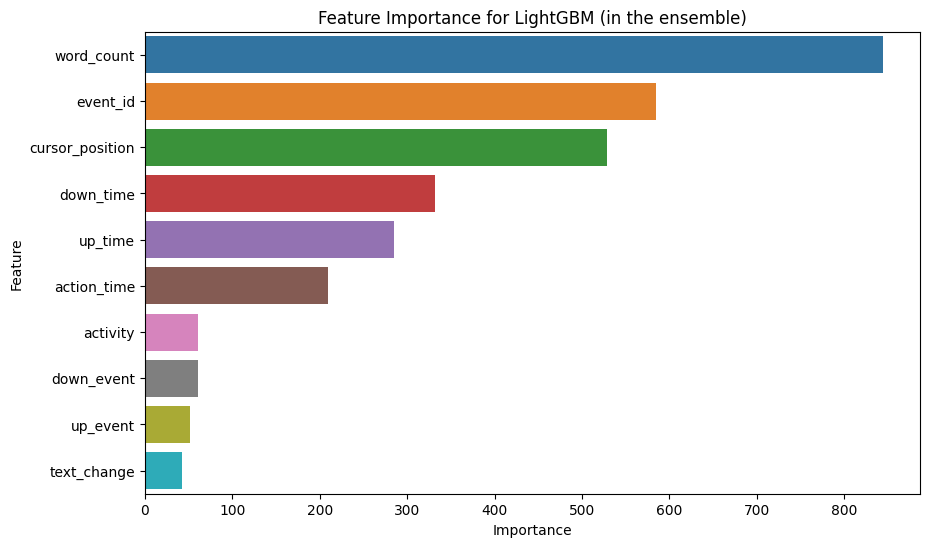

In [13]:
model1 = LGBMRegressor(random_state=42, device="gpu")
model1.fit(X_train, y_train)  
feature_importance_lgbm = model1.feature_importances_
feature_names = X_train.columns
feature_importance_lgbm_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance_lgbm})
feature_importance_lgbm_df = feature_importance_lgbm_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_lgbm_df)
plt.title('Feature Importance for LightGBM (in the ensemble)')
plt.show()


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Generating predictions
    </div>

In [14]:
test_features = preprocess_data(test_logs.drop('id', axis=1))
test_predictions = ensemble.predict(test_features)

100%|██████████| 4/4 [00:00<00:00, 1742.91it/s]


<div style="background-color:#F0E3D2; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 2px solid #19180F; border-radius:10px"> 
📌<b> Generating submission file
    </div>

In [15]:
test_predictions

array([2.55044658, 2.40786866, 2.38008822, 3.16599029, 2.87465592,
       3.33922666])

In [16]:
submission = pd.DataFrame({'id': test_logs['id'], 'score': test_predictions})

In [17]:
submission_grouped = submission.groupby('id')['score'].mean().reset_index()

submission_grouped.to_csv('/kaggle/working/submission.csv', index=False)

submission_grouped

,id,score
0,0000aaaa,2.479158
1,2222bbbb,2.773039
2,4444cccc,3.106941
